# Install*

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 9.0MB/s 


# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

Wed Jun  2 10:52:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)

['data-20210420T111231Z-001.zip',
 'kowiki',
 'kowiki_32000.model',
 'kowiki_32000.vocab',
 'kowiki_mecab_32000.model',
 'kowiki_mecab_32000.vocab',
 'nsmc',
 'question_pair',
 'songys-chat']

In [ ]:
sychat_dir = os.path.join(data_dir, "songys-chat")
if not os.path.isdir(sychat_dir):
    os.makedirs(sychat_dir)
os.listdir(sychat_dir)

['lstm.hdf5', 'lstm.csv', 'lstm_dot.csv', 'lstm_dot.hdf5']

# Vocabulary*

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'kowiki', 'kowiki_32000.model'))

True

# Transformer

In [ ]:
args.d_model = 256  # d_model: model hidden dim
args.n_head = 4  # n_head: multi head attention head number
args.d_head = 64  # d_head: multi head attention head dim
args.dropout = 0.1  # dropout: dropout rate
args.d_ff = 1024  # d_ff: feed forward dim
args.norm_eps = 1e-9  # norm_eps: layernormal epsilon
args.n_layer = 3  # n_layer: layer number
args.n_seq = 128  # n_seq: sequence max number
args.n_vocab = len(vocab)  # n_vocab: vocab count
args.i_pad = vocab.pad_id()  # i_pad: vocab pad id

args

Namespace(d_ff=1024, d_head=64, d_model=256, dropout=0.1, i_pad=0, n_head=4, n_layer=3, n_seq=128, n_vocab=32007, norm_eps=1e-09, seed=1234)

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    # 0인 부분 확인
    mask = tf.math.equal(tokens, i_pad)
    # boolean -> float 32
    mask = tf.cast(mask, tf.float32)
    # expand dimension for n_seq
    mask = tf.expand_dims(mask, axis=1)
    return mask

In [ ]:
def get_causal_mask(tokens, i_pad=0):
    """
    causal mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: causal and pad mask (causal or pad: 1, other: 0)
    """
    # 개수 조회
    n_seq = tf.shape(tokens)[1]
    # make ahead mask
    mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    # expand dim for bs
    mask = tf.expand_dims(mask, axis=0)
    # get pad_mask
    pad_mask = get_pad_mask(tokens, i_pad)
    # mask all ahead_mask or pad_mask
    mask = tf.maximum(mask, pad_mask)
    return mask

In [ ]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        Q, K, V, attn_mask = inputs
        # matmul Q, K (transpose_b=True)
        attn_score = tf.matmul(Q, K, transpose_b=True)
        # get scale = d_model ** 0.5
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        # divide by scale
        attn_scale = tf.math.divide(attn_score, scale)
        # do mask (subtract 1e-9 for masked value)
        attn_scale -= 1.e9 * attn_mask
        # calculate attention prob
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        # weighted sum of V
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, args, name="multi_head_attention"):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = args.d_model
        self.n_head = args.n_head
        self.d_head = args.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(self.n_head * self.d_head)
        self.W_K = tf.keras.layers.Dense(self.n_head * self.d_head)
        self.W_V = tf.keras.layers.Dense(self.n_head * self.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(self.d_model)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        Q, K, V, attn_mask = inputs
        # build multihead Q, K, V
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [-1, tf.shape(Q)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [-1, tf.shape(K)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [-1, tf.shape(V)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        # build multihead mask
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out_m = self.attention((Q_m, K_m, V_m, attn_mask_m))  # (bs, n_head, Q_len, d_head)
        # transpose and reshape
        attn_out_t = tf.transpose(attn_out_m, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out_c = tf.reshape(attn_out_t, [-1, tf.shape(Q)[1], self.n_head * self.d_head])  # (bs, Q_len, d_model)
        # linear for output
        attn_out = self.W_O(attn_out_c) # (bs, Q_len, d_model)
        return attn_out

In [ ]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, args, name="feed_forward"):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(args.d_ff, activation=tf.nn.relu)
        self.W_2 = tf.keras.layers.Dense(args.d_model)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        # linear W_1 and W_2
        ff_val = self.W_1(inputs)
        ff_val = self.W_2(ff_val)
        return ff_val

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, args, name='encoder_layer'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(args)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps)

        self.ffn = PositionWiseFeedForward(args)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps)

        self.dropout = tf.keras.layers.Dropout(args.dropout)
 
    def call(self, inputs):
        """
        layer 실행
        :param inputs: enc_hidden, self_mask tuple
        :return enc_out: EncoderLayer 실행 결과
        """
        enc_hidden, self_mask = inputs
        # self attention
        self_attn_val = self.self_attention((enc_hidden, enc_hidden, enc_hidden, self_mask))
        # add and layer normal
        norm1_val = self.norm1(enc_hidden + self.dropout(self_attn_val))
        
        # feed forward
        ffn_val = self.ffn(norm1_val)
        # add and layer normal
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    Decoder Layer Class
    """
    def __init__(self, args, name='decoder_layer'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(args)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps)

        self.ende_attn = MultiHeadAttention(args)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps)

        self.ffn = PositionWiseFeedForward(args)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps)

        self.dropout = tf.keras.layers.Dropout(args.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: dec_hidden, enc_out, self_mask, ende_mask tuple
        :return dec_out: DecoderLayer 실행 결과
        """
        dec_hidden, enc_out, self_mask, ende_mask = inputs
        # self attention
        self_attn_val = self.self_attention((dec_hidden, dec_hidden, dec_hidden, self_mask))
        # add and layer normal
        norm1_val = self.norm1(dec_hidden + self.dropout(self_attn_val))

        # encoder and decoder attention
        ende_attn_val = self.ende_attn((norm1_val, enc_out, enc_out, ende_mask))
        # add and layer normal
        norm2_val = self.norm2(norm1_val + self.dropout(ende_attn_val))

        # feed forward
        ffn_val = self.ffn(norm2_val)
        # add and layer normal
        dec_out = self.norm3(norm2_val + self.dropout(ffn_val))

        return dec_out

In [ ]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, args, name='weight_shared_embedding'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = args.n_vocab
        self.d_model = args.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope('shared_embedding_weight'):
            self.shared_weights = self.add_weight(
                'weights',
                shape=[self.n_vocab, self.d_model],
                initializer=tf.keras.initializers.TruncatedNormal(stddev=self.d_model ** -0.5)
            )

    def call(self, inputs, mode='embedding'):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == 'embedding':
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == 'linear':
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f'mode {mode} is not valid.')
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        # lookup by gather
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        # muliply d_model ** 0.5
        embed *= self.d_model ** 0.5
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        # matmul inputs, shared_weights (transpose_b=True)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True) # 
        return outputs

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, args, name='position_embedding'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        pos_encoding = PositionalEmbedding.get_sinusoid_encoding(args.n_seq, args.d_model)
        self.embedding = tf.keras.layers.Embedding(args.n_seq, args.d_model, trainable=False, weights=[pos_encoding]) # 학습이 안되게 trainable = False

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        # make position (0...n_seq)
        position = tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True) # [1,1,1,1,1] -> [1,2,3,4,5] ->[0,1,2,3,4]
        position = tf.cast(position, tf.int32)
        # embedding lookup
        embed = self.embedding(position)
        return embed

    @staticmethod
    def get_sinusoid_encoding(n_seq, d_model): # 바로 호출가능, class 만들지 않아도
        """
        sinusoid encoding 생성
        :param n_seq: sequence number
        :param n_seq: model hidden dimension
        :return: positional encoding table
        """
        # calculate angle
        exs = np.array([2 * (i_ang // 2) / d_model for i_ang in range(d_model)])
        angles = np.power(10000, exs)
        pos = np.array([[i] for i in range(n_seq)])
        pos_encoding = pos / angles
        # sin even number
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
        # cos odd number
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
        return tf.cast(pos_encoding, tf.float32)

In [ ]:
class Transformer(tf.keras.Model):
    """
    Transformer Class
    """
    def __init__(self, args, name='transformer'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = args.i_pad
        self.embedding = SharedEmbedding(args)
        self.position = PositionalEmbedding(args)
        
        self.encoder_layers = [EncoderLayer(args, name=f'encoder_layer_{i}') for i in range(args.n_layer)]
        self.decoder_layers = [DecoderLayer(args, name=f'decoder_layer_{i}') for i in range(args.n_layer)]

        self.dropout = tf.keras.layers.Dropout(args.dropout) # embedding 이 attention에 들어가기 전에  dropout

    def call(self, inputs):
        """
        layer 실행
        :param inputs: enc_tokens, dec_tokens tuple
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, dec_tokens = inputs
        # encoder self attention mask
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)
        # decoder self attention mask
        dec_self_mask = get_causal_mask(dec_tokens, self.i_pad)
        # encoder and decoder attention mask
        enc_dec_mask = get_pad_mask(enc_tokens, self.i_pad)

        # enc_tokens, dec_tokens embedding lookup
        enc_embed = self.get_embedding(enc_tokens)
        dec_embed = self.get_embedding(dec_tokens)

        # dropout for enc_embed
        enc_hidden = self.dropout(enc_embed)
        # call encoder layers
        for encoder_layer in self.encoder_layers:
            enc_hidden = encoder_layer((enc_hidden, enc_self_mask))
        
        # dropout for dec_embed
        dec_hidden = self.dropout(dec_embed)
        # call decoder layers
        for decoder_layer in self.decoder_layers:
            dec_hidden = decoder_layer((dec_hidden, enc_hidden, dec_self_mask, enc_dec_mask))

        # call weight shared embedding (model=linear)
        logits = self.embedding(dec_hidden, mode='linear')
        return logits
    
    def get_embedding(self, tokens):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens)
        return embed

In [ ]:
def build_model(args):
    """
    Transformer Model
    :param args: Args 객체
    """
    enc_inputs = tf.keras.layers.Input((None,))  # (bs, ?)
    dec_inputs = tf.keras.layers.Input((None,))  # (bs, ?)

    transformer = Transformer(args)
    logits = transformer((enc_inputs, dec_inputs))
    y_pred = tf.keras.layers.Softmax(name="lm")(logits)

    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=y_pred)
    return model

# Data*

In [ ]:
# 파일 다운로드 및 목록 확인
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
os.listdir('./')

--2021-06-02 11:17:32--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv [following]
--2021-06-02 11:17:32--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv’

ChatbotData .csv    100%[===================>] 868.99K  --.-KB/s    in 0.05s   

2021-06-02 11:17:33 (16.6 MB/s) - ‘ChatbotData .csv’ saved [889842/889842]



['.config', 'drive', 'ChatbotData .csv', 'sample_data']

In [ ]:
# 파일명 변경 및 목록 확인
!mv 'ChatbotData .csv' ChatbotData.csv
os.listdir('./')

['.config', 'drive', 'ChatbotData.csv', 'sample_data']

# Loss & Acc*

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [ ]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# Scheduler

In [ ]:
class InverseSquareRootSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    TransformerSchedule class
    """
    def __init__(self, d_model, warmup_steps=4000):
        """
        생성자
        :param d_model: 모델 hidden
        :param warmup_steps: warmup steps
        """
        super().__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        # calculate arg1 step_num ** -0.5
        arg1 = tf.math.rsqrt(step_num) # 분모에 루트
        # print(arg1)
        # calculate arg2 step_num * warmup_steps ** -1.5
        arg2 = step_num * (self.warmup_steps**-1.5)
        # print(arg2)
        # calcualte arg (min arg1 vs arg2)
        arg = tf.math.minimum(arg1, arg2)
        # print(arg)
        # calcualte lr (d_model ** -0.5 * arg)
        lr = tf.math.rsqrt(self.d_model) * arg
        return lr

In [ ]:
schedule = InverseSquareRootSchedule(args.d_model, warmup_steps=100)
schedule(float(101))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0062189824>

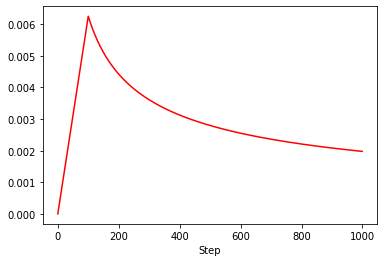

In [ ]:
# compute lr
test_schedule = InverseSquareRootSchedule(args.d_model, warmup_steps=100)
lrs = []
for step in range(1000):
    lrs.append(test_schedule(float(step)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

# All Data Project

## Train 데이터 생성

In [ ]:
# data load
df_train = pd.read_csv('ChatbotData.csv')
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# null 제거
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# Q 길이
q_length = df_train["Q"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
q_length.head(10), q_length.max()

(0     5
 1     6
 2     9
 3    10
 4     5
 5     7
 6     5
 7     7
 8    11
 9     9
 Name: Q, dtype: int64, 27)

In [ ]:
# A 길이
a_length = df_train["A"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
a_length.head(10), a_length.max()

(0    6
 1    6
 2    6
 3    6
 4    9
 5    9
 6    9
 7    7
 8    6
 9    6
 Name: A, dtype: int64, 39)

In [ ]:
def make_data(df, vocab, n_enc_seq, n_dec_seq):
    """
    chat 학습 데이터 생성
    :param df: data frame
    :param df: vocab
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return dec_labels: decoder label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1  # [BOS] or [EOS]
    # inputa & labels
    enc_inputs = []
    dec_inputs = []
    dec_labels = []
    # 데이터 생성
    for i, row in tqdm(df.iterrows(), total=len(df)):
        Q = row['Q']
        A = row['A']
        # print(Q, '/', A)
        # tokenize
        tokens_q = vocab.encode_as_ids(Q)
        # print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_ids(A)
        # print(len(tokens_a), ':', tokens_a)
       
        # 최대 길이로 자르기
        tokens_q = tokens_q[:n_enc_max]
        # print(len(tokens_q), ':', tokens_q)
        tokens_a = tokens_a[:n_dec_max]
        # print(len(tokens_a), ':', tokens_a)
       
        # input & label 정의
        enc_input = tokens_q
        # print(len(enc_input), ':', enc_input)
        dec_input = [vocab.bos_id()] + tokens_a
        # print(len(dec_input), ':', dec_input)
        dec_label = tokens_a + [vocab.eos_id()]
        # print(len(dec_label), ':', dec_label)
       
        # pad 추가
        enc_input += [0] * (n_enc_seq - len(enc_input))
        # print(len(enc_input), ':', enc_input)
        dec_input += [0] * (n_dec_seq - len(dec_input))
        # print(len(dec_input), ':', dec_input)
        dec_label += [0] * (n_dec_seq - len(dec_label))
        # print(len(dec_label), ':', dec_label)
       
        # 값 저장
        enc_inputs.append(enc_input)
        dec_inputs.append(dec_input)
        dec_labels.append(dec_label)
    # to numpy array
    enc_inputs = np.array(enc_inputs)
    dec_inputs = np.array(dec_inputs)
    dec_labels = np.array(dec_labels)
    return enc_inputs, dec_inputs, dec_labels

In [ ]:
train_enc_inputs, train_dec_inputs, train_dec_labels = make_data(df_train, vocab, 27, 40)
train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[   92,    56,    10, ...,     0,     0,     0],
        [   36,    44,  1075, ...,     0,     0,     0],
        [   39,   999,   387, ...,     0,     0,     0],
        ...,
        [ 3531,  8607, 18488, ...,     0,     0,     0],
        [10149,  7479,  1232, ...,     0,     0,     0],
        [21584,    71,  1113, ...,     0,     0,     0]]),
 array([[    2,  2424,    19, ...,     0,     0,     0],
        [    2,  3975,    61, ...,     0,     0,     0],
        [    2,  1910,    18, ...,     0,     0,     0],
        ...,
        [    2,  1695,     1, ...,     0,     0,     0],
        [    2,   423,  9250, ...,     0,     0,     0],
        [    2, 14787,    98, ...,     0,     0,     0]]),
 array([[ 2424,    19,   345, ...,     0,     0,     0],
        [ 3975,    61,   976, ...,     0,     0,     0],
        [ 1910,    18,  8244, ...,     0,     0,     0],
        ...,
        [ 1695,     1,  8406, ...,     0,     0,     0],
        [  423,  9250,   507, ...,     0,    

## Modeling

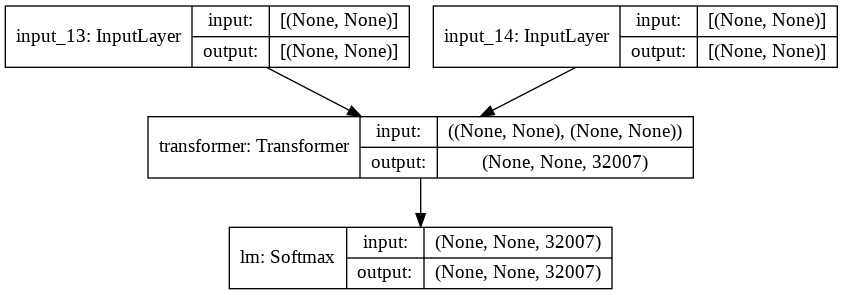

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_enc_inputs[:4], train_dec_inputs[:4]))

array([[[6.74611219e-05, 1.25326324e-05, 4.78840448e-05, ...,
         2.23014886e-05, 1.71486914e-04, 1.78506525e-05],
        [7.25571808e-05, 1.83953762e-05, 3.09448806e-05, ...,
         1.99326423e-05, 1.65173566e-04, 1.41503488e-05],
        [6.53285388e-05, 1.49690995e-05, 2.03654945e-05, ...,
         2.67667074e-05, 1.47942905e-04, 1.24827920e-05],
        ...,
        [1.85566081e-04, 1.20641753e-05, 2.59813787e-05, ...,
         1.96272886e-05, 1.24595128e-04, 1.38284995e-05],
        [1.91732703e-04, 1.26169789e-05, 2.63877428e-05, ...,
         1.97374193e-05, 1.25737060e-04, 1.35339706e-05],
        [2.03265387e-04, 1.32374089e-05, 2.65446542e-05, ...,
         1.99157184e-05, 1.28062748e-04, 1.35072305e-05]],

       [[2.35212374e-05, 1.73176704e-05, 5.26429285e-05, ...,
         1.70876501e-05, 5.56314517e-05, 1.65091351e-05],
        [2.61086570e-05, 2.17876714e-05, 1.40578650e-05, ...,
         1.86028046e-05, 6.64280087e-05, 1.31311008e-05],
        [2.18900059e-05, 

## Train

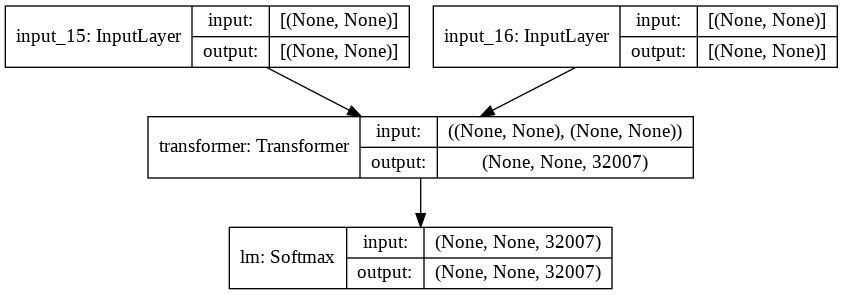

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
learning_rate = InverseSquareRootSchedule(args.d_model, warmup_steps=1000) # peak점
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
model.compile(loss=lm_loss, optimizer=optimizer, metrics=[lm_acc])
# model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=30)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(sychat_dir, "transformer.hdf5"),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(sychat_dir, "transformer.csv"))

In [ ]:
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_dec_labels,
                    epochs=50,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

 #47 step을 해서 한 epoch당  47번 업데이트 되는거지 -> loss,im acc도 47번 업뎃되는거야 한 epoch당
 # 보통 한번에 안끝내고 논문에서는
 # 5회해서 평균내고 ,편자를 내는 식으로 함
 # 학습이 안되면 무조건 데이터 부터
 # 일단 무조건 작은 model부터 만들어서 작은 data로 학습이 되는지 확인하고
 # 되면 조금씩 둘다 늘려가는 방법을 채택
 # layer를 24개씩 쌓는거지.. 그게 GPT3 유형인거고
 # schedular를 안쓰면 학습이 잘 안되는 경우도 있음 -> but 다양한 유형의 schedular가 잇음

Epoch 1/50
47/47 [==============================] - 35s 566ms/step - loss: 2.2483 - lm_acc: 0.0749

Epoch 00001: lm_acc improved from -inf to 0.07494, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/transformer.hdf5
Epoch 2/50
47/47 [==============================] - 26s 560ms/step - loss: 1.7079 - lm_acc: 0.2147

Epoch 00002: lm_acc improved from 0.07494 to 0.21474, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/transformer.hdf5
Epoch 3/50
47/47 [==============================] - 26s 547ms/step - loss: 1.2809 - lm_acc: 0.2903

Epoch 00003: lm_acc improved from 0.21474 to 0.29027, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/transformer.hdf5
Epoch 4/50
47/47 [==============================] - 26s 555ms/step - loss: 1.1293 - lm_acc: 0.3358

Epoch 00004: lm_acc improved from 0.29027 to 0.33580, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/

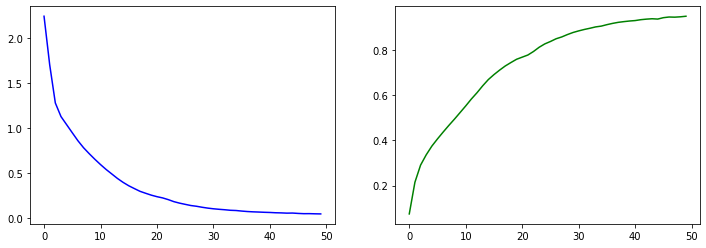

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='accuracy')

plt.show()

## BLEU

In [ ]:
def get_ngram(tokens, ngram):
    # tokens n-gram
    counter = collections.defaultdict(int)
    for i in range(len(tokens) - ngram + 1):
        # n-gram 별 count
        key = tuple(tokens[i:i+ngram])
        counter[key] += 1
    return  counter

In [ ]:
def get_ngram_clip(candidate, references, ngram):
    # max ref counter
    max_counter = collections.defaultdict(int)
    # check max count
    for ref in references:
        ref_counter = get_ngram(ref, ngram)
        for key, cnt in ref_counter.items():
            max_counter[key] = max(max_counter[key], ref_counter.get(key, 0))
    
    # candidate counter
    can_counter = get_ngram(candidate, ngram)
    # clip counter
    clip_counter = collections.defaultdict(int)
    for key, cnt in can_counter.items():
        clip_counter[key] = min(can_counter[key], max_counter.get(key, 0))
    return clip_counter

In [ ]:
def get_ngram_precision(candidate, references, ngram):
    # clip counter
    clip_counter = get_ngram_clip(candidate, references, ngram) 
    n_clip = sum(clip_counter.values())
    # ref counter
    can_counter = get_ngram(candidate, ngram)
    n_total = sum(can_counter.values())

    return n_clip / max(n_total, 1)  # 분모 0 방지

In [ ]:
def get_brevity_penalty(candidate, references):
    can_len = len(candidate)
    ref_len = min([len(reference) for reference in references])

    if can_len == 0:  # empty string
        return 0
    elif can_len > ref_len:
        return 1
    else:
        return np.exp(1 - ref_len / can_len)

In [ ]:
def get_bleu_score(candidate, references, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = get_brevity_penalty(candidate, references) # BP
    p_n = []
    for i in range(len(weights)):
        p_n.append(get_ngram_precision(candidate, references, i + 1))
    score = [w * np.log(p) if p != 0 else 0 for p, w in zip(p_n, weights)]
    score = np.sum(score)
    score = bp * np.exp(score)
    return score

In [ ]:
import nltk.translate.bleu_score as bleu
from nltk import ngrams

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "transformer.hdf5"))

In [ ]:
model.compile(loss=lm_loss, optimizer=optimizer, metrics=[lm_acc])

In [ ]:
# 100개만 확인
valid_enc_inputs = train_enc_inputs[:100]
valid_dec_inputs = train_dec_inputs[:100]
valid_dec_labels = train_dec_labels[:100]

In [ ]:
# 평가
model.evaluate((valid_enc_inputs, valid_dec_inputs), valid_dec_labels, batch_size=128)

1/1 [==============================] - 3s 3s/step - loss: 0.0032 - lm_acc: 0.9957


[0.0032065268605947495, 0.9956849813461304]

In [ ]:
references = []
for row in valid_dec_labels:
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    references.append(string)
references

[['▁하루', '가', '▁또', '▁가네', '요', '.'],
 ['▁위로', '해', '▁드', '립', '니다', '.'],
 ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'],
 ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'],
 ['▁눈', '살이', '▁', '찌', '푸', '려', '지', '죠', '.'],
 ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'],
 ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'],
 ['▁잘', '▁모르고', '▁있을', '▁수도', '▁있어', '요', '.'],
 ['▁시간을', '▁정하고', '▁해', '보', '세요', '.'],
 ['▁시간을', '▁정하고', '▁해', '보', '세요', '.'],
 ['▁자랑하는', '▁자리', '니까', '요', '.'],
 ['▁그', '▁사람도', '▁그럴', '▁거', '예', '요', '.'],
 ['▁그', '▁사람도', '▁그럴', '▁거', '예', '요', '.'],
 ['▁혼자', '를', '▁즐기', '세요', '.'],
 ['▁돈', '은', '▁다시', '▁들어올', '▁거', '예', '요', '.'],
 ['▁땀', '을', '▁식', '혀', '주', '세요', '.'],
 ['▁', '어서', '▁', '잊', '고', '▁새', '출', '발', '▁하', '세요', '.'],
 ['▁빨리', '▁집에', '▁돌아가', '서', '▁끄', '고', '▁나오', '세요', '.'],
 ['▁빨리', '▁집에', '▁돌아가', '서', '▁끄', '고', '▁나오', '세요', '.'],
 ['▁다음', '▁달', '에는', '▁더', '▁절약', '해', '봐', '요', '.'],
 ['▁따뜻하', '게', '▁사', '세요', '!'],
 ['▁다음', '▁달', '에는', '▁더', '▁절약', 

In [ ]:
# 예측
y_pred = model.predict((valid_enc_inputs, valid_dec_inputs))
y_pred

array([[[3.07084020e-17, 4.93074366e-11, 2.90353880e-10, ...,
         2.68522745e-17, 2.76004570e-08, 1.40241988e-16],
        [2.58740756e-17, 4.06224776e-10, 3.65813796e-10, ...,
         1.71493434e-17, 3.18322191e-09, 7.68779610e-17],
        [5.14460879e-17, 2.46310802e-11, 1.27445188e-09, ...,
         5.30694431e-17, 1.66294853e-07, 8.62970997e-17],
        ...,
        [3.97934967e-16, 5.16116438e-09, 5.04054114e-08, ...,
         7.57978616e-17, 2.88963406e-07, 3.56679560e-15],
        [5.29692901e-16, 7.69400099e-09, 5.90932139e-08, ...,
         1.02080288e-16, 4.58682905e-07, 5.02717781e-15],
        [7.47658671e-16, 1.61708300e-08, 7.93809392e-08, ...,
         1.52838850e-16, 9.11384177e-07, 7.12939754e-15]],

       [[8.48156113e-15, 2.39779474e-10, 2.80396115e-08, ...,
         6.92490558e-15, 1.30805522e-09, 2.18086115e-14],
        [9.34468784e-17, 9.86126545e-13, 1.71483262e-11, ...,
         1.27456118e-16, 6.91729035e-11, 5.25479071e-16],
        [9.68648879e-16, 

In [ ]:
# greedy decoding
y_pred_class = tf.argmax(y_pred, axis=-1).numpy()
y_pred_class

array([[2424,   19,  345, ..., 2424, 2424, 2424],
       [3975,   61,  976, ..., 7509, 7509, 7509],
       [1910,   18, 8244, ...,   10,   10,   10],
       ...,
       [7288,   20,  506, ..., 7288, 7288, 7288],
       [7288,    8, 2489, ..., 9537, 9537, 9537],
       [ 289, 4853, 1316, ...,   10,  120,  120]])

In [ ]:
candidates = []
for row in y_pred_class:
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    candidates.append(string)
candidates

[['▁하루', '가', '▁또', '▁가네', '요', '.'],
 ['▁위로', '해', '▁드', '립', '니다', '.'],
 ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'],
 ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'],
 ['▁눈', '살이', '▁', '찌', '푸', '려', '지', '죠', '.'],
 ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'],
 ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'],
 ['▁잘', '▁모르고', '▁있을', '▁수도', '▁있어', '요', '.'],
 ['▁시간을', '▁정하고', '▁해', '보', '세요', '.'],
 ['▁시간을', '▁정하고', '▁해', '보', '세요', '.'],
 ['▁자랑하는', '▁자리', '니까', '요', '.'],
 ['▁그', '▁사람도', '▁그럴', '▁거', '예', '요', '.'],
 ['▁그', '▁사람도', '▁그럴', '▁거', '예', '요', '.'],
 ['▁혼자', '를', '▁즐기', '세요', '.'],
 ['▁돈', '은', '▁다시', '▁들어올', '▁거', '예', '요', '.'],
 ['▁땀', '을', '▁식', '혀', '주', '세요', '.'],
 ['▁', '어서', '▁', '잊', '고', '▁새', '출', '발', '▁하', '세요', '.'],
 ['▁빨리', '▁집에', '▁돌아가', '서', '▁끄', '고', '▁나오', '세요', '.'],
 ['▁빨리', '▁집에', '▁돌아가', '서', '▁끄', '고', '▁나오', '세요', '.'],
 ['▁다음', '▁달', '에는', '▁더', '▁절약', '해', '봐', '요', '.'],
 ['▁따뜻하', '게', '▁사', '세요', '!'],
 ['▁다음', '▁달', '에는', '▁더', '▁절약', 

In [ ]:
bleu_scores = []
for reference, candidate in zip(references, candidates):
    bleu_score = bleu.sentence_bleu([reference], candidate)
    bleu_scores.append(bleu_score)
    print(bleu_score, ":", reference, "/", candidate)
np.mean(bleu_scores)

1.0 : ['▁하루', '가', '▁또', '▁가네', '요', '.'] / ['▁하루', '가', '▁또', '▁가네', '요', '.']
1.0 : ['▁위로', '해', '▁드', '립', '니다', '.'] / ['▁위로', '해', '▁드', '립', '니다', '.']
1.0 : ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'] / ['▁여행', '은', '▁언제나', '▁좋', '죠', '.']
1.0 : ['▁여행', '은', '▁언제나', '▁좋', '죠', '.'] / ['▁여행', '은', '▁언제나', '▁좋', '죠', '.']
1.0 : ['▁눈', '살이', '▁', '찌', '푸', '려', '지', '죠', '.'] / ['▁눈', '살이', '▁', '찌', '푸', '려', '지', '죠', '.']
1.0 : ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'] / ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.']
1.0 : ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.'] / ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해', '요', '.']
1.0 : ['▁잘', '▁모르고', '▁있을', '▁수도', '▁있어', '요', '.'] / ['▁잘', '▁모르고', '▁있을', '▁수도', '▁있어', '요', '.']
1.0 : ['▁시간을', '▁정하고', '▁해', '보', '세요', '.'] / ['▁시간을', '▁정하고', '▁해', '보', '세요', '.']
1.0 : ['▁시간을', '▁정하고', '▁해', '보', '세요', '.'] / ['▁시간을', '▁정하고', '▁해', '보', '세요', '.']
1.0 : ['▁자랑하는', '▁자리', '니까', '요', '.'] / ['▁자랑하는', '▁자리', '니까'

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.9924289353549767

## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "transformer.hdf5"))

In [ ]:
def do_chat(vocab, model, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q_id = vocab.encode_as_ids(string) # encoder self attention에서 mask로 다 막아줘서 굳이 input으로 pad 안만들어줘도 되지
    # q_id = vocab.encode_as_ids(string)

    # answer
    a_id = [vocab.bos_id()]

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        # print(q_id)
        # print(a_id)
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = int(np.argmax(prob))
        # print(word_id)
        if word_id == vocab.eos_id():
            break
        a_id.append(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    # print(predict_id)
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
string = '남에게 피해주지 않는 건 기본이죠.'
do_chat(vocab, model, 40, string)

'남이니 신경쓰지 마세요.'

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, 40, string)
    print(f'답변 > {predict_str}')

질문 > 기분이 좋지 않아
답변 > 음
질문 > 너는 기분이 어때?
답변 > 모두 제 잘못입니다.
질문 > 노래좀 틀어줘
답변 > 감기 조심하세요.
질문 > 나 몸이 조금 안좋아
답변 > 피로를 풀어야 할 것 같아요.
질문 > 어떻게 피로를 풀면 될까?
답변 > 미래는 배우자가 아니라면 그렇죠.
질문 > 사랑해
답변 > 하늘 만큼 땅 만큼 사랑해요.


KeyboardInterrupt: ignored